## Load data

In [1]:
import sys
 
sys.path.insert(0, "../")

In [2]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

data = pd.read_csv(r"../extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/miniconda3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/dwalke/git/sbc/feature_variation/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/sbc/feature_variation/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [3]:
import torch

y_train = torch.tensor(data_analysis.get_y_train(), dtype=torch.long)
X_train = torch.tensor(data_analysis.get_X_train(), dtype=torch.float)

## Define model

In [4]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import torch
from dataAnalysis.Constants import FEATURES
from torch_geometric.loader import NeighborLoader

class GraphNeuralNetwork(torch.nn.Module):

    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(GraphNeuralNetwork, self).__init__()
        
        input_dim = len(FEATURES)          
        self.conv1 = SAGEConv(input_dim, hidden_dim, normalize=True, project= True, aggr = "mean", root_weight = True, dropout=0.0)
        self.conv_end = SAGEConv(hidden_dim, out_channels, aggr = "mean", root_weight = True)


    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv_end(x, edge_index)
        return x
           
    def predict_proba(self, graph):
        y_pred_proba_all = torch.tensor([])
        loader = NeighborLoader(graph, num_neighbors=[-1,-1], batch_size = 100000)
        with torch.inference_mode():
            self.eval()
            for i, batch in enumerate(loader):
                logits = self.forward(batch)
                scores = torch.sigmoid(torch.squeeze(logits))
                scores = torch.unsqueeze(scores, 0)
                proba_predict = torch.concat((1- scores, scores), dim = 0)
                transp_proba_pred = torch.transpose(proba_predict, 0, 1)
                y_pred_proba_all = torch.concat((y_pred_proba_all, transp_proba_pred), dim = 0)
        return y_pred_proba_all
            
    def predict(self, graph):
        return torch.round(self.predict_proba(graph)[:, 1])

## Load trained model

In [5]:
model = GraphNeuralNetwork().cpu() #.to(device)
model.load_state_dict(torch.load("../models/model_homognn_88.pt", map_location=torch.device('cpu')))
model.eval()

GraphNeuralNetwork(
  (conv1): SAGEConv(7, 128, aggr=mean)
  (conv_end): SAGEConv(128, 1, aggr=mean)
)

## Create graph from synthetic dataset

In [6]:
from torch_geometric.nn import knn_graph
from dataAnalysis.FeatureImportance import FeatureImportance

def normalize(tensor):
    if not torch.is_tensor(tensor):
        tensor = torch.from_numpy(tensor).type(torch.float)
    mean = torch.mean(tensor, dim = 0)
    std = torch.std(tensor, dim = 0)
    mean_diff = tensor - mean
    return mean_diff / std


feature_importance = FeatureImportance(X_train)
X_all_fv = normalize(feature_importance.X_all_fv)
edge_index = knn_graph(X_all_fv ,k = 1, loop = True, num_workers = -1)

In [7]:
from torch_geometric.data import Data

graph = Data(x= X_all_fv,  edge_index = edge_index.type(torch.long))

## Feature importance

In [8]:
feature_importance.set_model_input([graph])

Ratio of diseased men/women over all CBCs for Homogeneous GNN 27.811984374999998	26.040999999999997


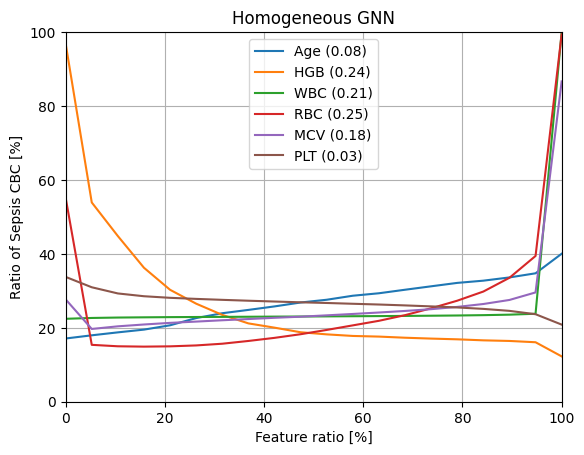

In [9]:
feature_importance.plot_feature_importance(model, title= "Homogeneous GNN", write=True)